### Sklift Practice

In [34]:
import pandas as pd 
import lightgbm as lgb

from sklift.models import SoloModel, TwoModels, ClassTransformation

from sklearn.model_selection import train_test_split

In [26]:
SEED = 23

### Sklift Submodules
- datasets
- models 
- metrics
- viz (vizualization)

https://www.uplift-modeling.com/en/latest/api/datasets/index.html

### Sklift.Datasets
Для Uplift модели данные должны собираться определенным образом, поэтому библиотека Sklift имеет ряд встроенных полезных datasets. Пример доступных datasets:
- Criteo
- Hillstrom
- X5
- Lenta 
- Megafon 

In [2]:
from sklift.datasets import (
    fetch_criteo, fetch_x5, fetch_megafon, fetch_lenta, fetch_hillstrom
)

In [3]:
# Используем данные Megafon
data, target, treatment =  fetch_megafon(return_X_y_t=True)
data.shape

Megafon dataset:   0%|          | 0.00/276M [00:00<?, ?iB/s]

In [7]:
data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858


In [11]:
target.head()

0    0
1    0
2    0
3    0
4    0
Name: conversion, dtype: int64

In [12]:
treatment.head()

0      control
1      control
2    treatment
3    treatment
4    treatment
Name: treatment_group, dtype: object

In [13]:
# преобразуем treatment
treatment = treatment.map({'control': 0, 'treatment': 1})
treatment.head()

0         0
1         0
2         1
3         1
4         1
         ..
599995    1
599996    1
599997    1
599998    1
599999    0
Name: treatment_group, Length: 600000, dtype: int64

In [16]:
# train/test data
stratify_columns = pd.concat([treatment, target], axis=1)
display(stratify_columns.head())

,treatment_group,conversion
0,0,0
1,0,0
2,1,0
3,1,0
4,1,0


In [22]:
X_train, X_test, trtm_train, trtm_test, y_train, y_test = train_test_split(
    data,
    treatment,
    target,
    stratify=stratify_columns,
    test_size=0.3,
    random_state=SEED
)

print('Train Shape: ', X_train.shape)
print('Test Shape: ', X_test.shape)

Train Shape:  (420000, 50)
Test Shape:  (180000, 50)


### Sklift.Models
Модели библиотеки Sklift являются метамоделями, принимающие другие модели (sklear.estimator) соответствующие конвенкции sklearn
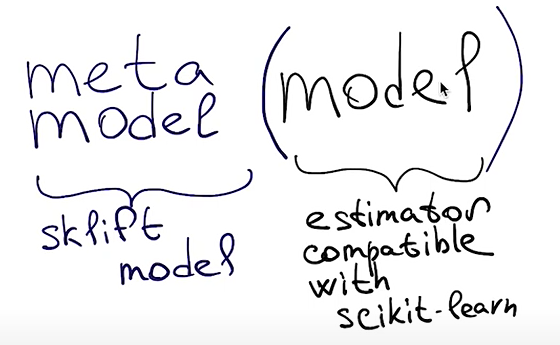

В качестве классификатора, используем lightgbm, а в качестве мета модели, пройдемся по доступными uplift моделям (S-Learnet, T-Learner, ...)

### Solo Model
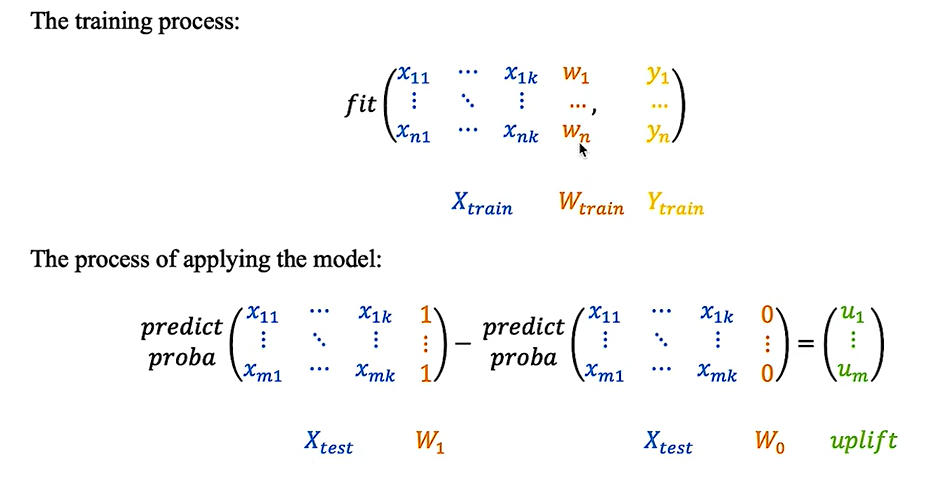

In [30]:
lgb_model = lgb.LGBMClassifier(random_state=SEED)
s_learner = SoloModel(lgb_model, method='dummy') # dummy: single/solo model

s_learner = s_learner.fit(X_train, y_train, trtm_train)
s_learner.predict(X_test)

array([ 0.55687069,  0.15274583, -0.07606831, ..., -0.01145626,
        0.04332285, -0.10538935])

### Solo Model (Treatment Interaction)
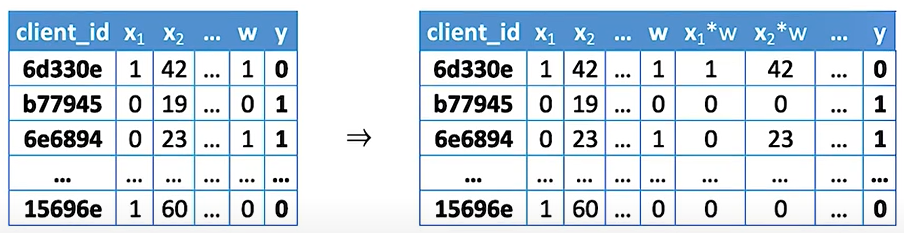

In [29]:
lgb_model = lgb.LGBMClassifier(random_state=SEED)
s_learner_ti = SoloModel(lgb_model, method='treatment_interaction')

s_learner_ti = s_learner_ti.fit(X_train, y_train, trtm_train)
s_learner_ti.predict(X_test)

array([ 0.74337967,  0.1294455 , -0.13057234, ...,  0.0669466 ,
        0.02717807, -0.10638702])

### Two Models (Vanilla)
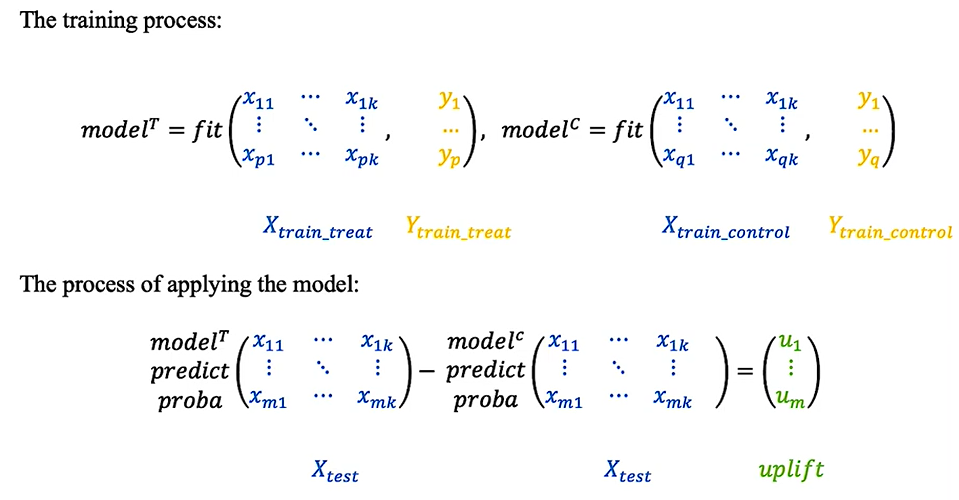

In [32]:
treatment_model = lgb.LGBMClassifier(random_state=SEED)
control_model = lgb.LGBMClassifier(random_state=SEED)

t_learner = TwoModels(
    estimator_trmnt=treatment_model,
    estimator_ctrl=control_model,
    method='vanilla'
)

t_learner = t_learner.fit(X_train, y_train, trtm_train)
t_learner.predict(X_test)

array([ 0.73276761,  0.13060083, -0.18470096, ...,  0.04806818,
        0.03249109, -0.08591987])

### Two Models (Перекрестные Модели / Dependent Data Representation)

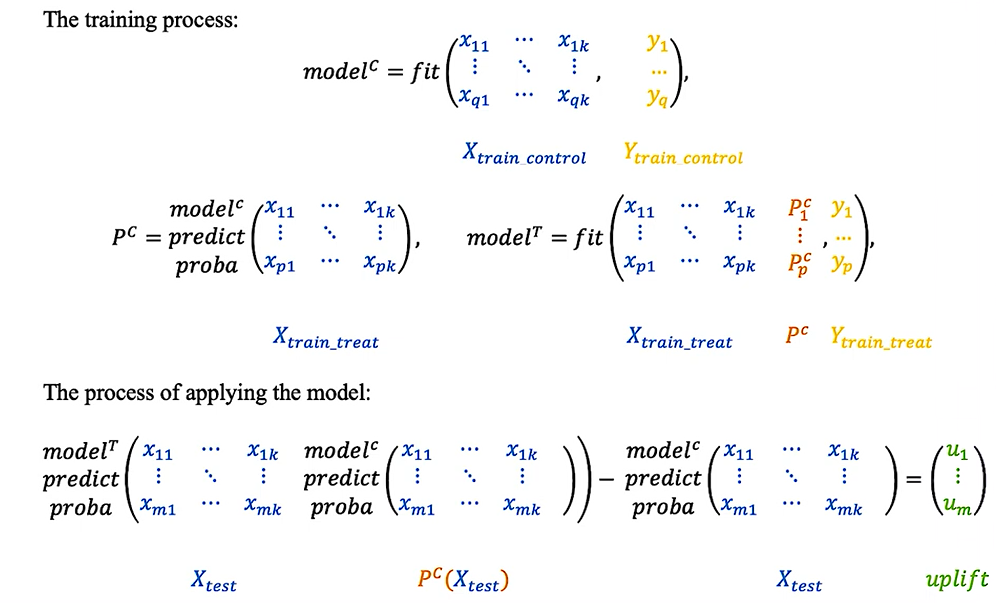

In [33]:
treatment_model = lgb.LGBMClassifier(random_state=SEED)
control_model = lgb.LGBMClassifier(random_state=SEED)

x_learner = TwoModels(
    estimator_trmnt=treatment_model,
    estimator_ctrl=control_model,
    method='ddr_control' # or ddr_treatment
)

x_learner = x_learner.fit(X_train, y_train, trtm_train)
x_learner.predict(X_test)

array([ 0.81249924,  0.12012553, -0.42866076, ...,  0.01302668,
        0.03950164, -0.09822269])

### Class Transformation
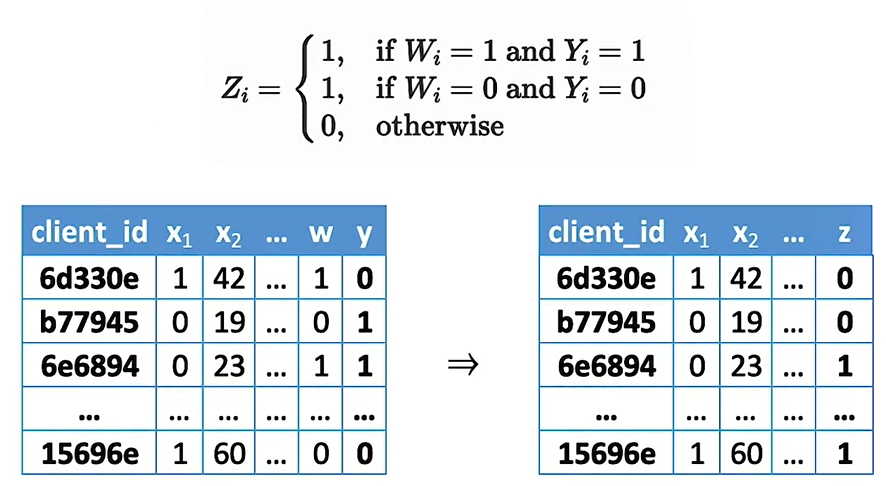

In [35]:
lgb_model = lgb.LGBMClassifier(random_state=SEED)
class_t = ClassTransformation(lgb_model)

class_t = class_t.fit(X_train, y_train, trtm_train)
class_t.predict(X_test)

array([ 0.55619545,  0.15202317, -0.20994833, ...,  0.16438074,
       -0.00170277, -0.2760137 ])